<a href="https://colab.research.google.com/github/ozlemakboyraz/Knee-OA-Classification-Project/blob/main/mobilenetv2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Train: 6105 Val: 826 Test: 1656
labels
Healthy     4848
Moderate     757
Severe       500
Name: count, dtype: int64
Augment sonrası Severe sayısı: 500

=== Epoch 1/10 started ===


Validation: 100%|██████████| 42/42 [00:03<00:00, 12.53batch/s]


Epoch 1/10 | Train Loss: 0.3646, Acc: 0.8575 | Val Loss: 0.2351, Acc: 0.9189

=== Epoch 2/10 started ===


Validation: 100%|██████████| 42/42 [00:03<00:00, 12.43batch/s]


Epoch 2/10 | Train Loss: 0.2333, Acc: 0.9094 | Val Loss: 0.2031, Acc: 0.9322

=== Epoch 3/10 started ===


Validation: 100%|██████████| 42/42 [00:03<00:00, 12.81batch/s]


Epoch 3/10 | Train Loss: 0.2040, Acc: 0.9265 | Val Loss: 0.1766, Acc: 0.9492

=== Epoch 4/10 started ===


Validation: 100%|██████████| 42/42 [00:03<00:00, 12.79batch/s]


Epoch 4/10 | Train Loss: 0.1810, Acc: 0.9327 | Val Loss: 0.1679, Acc: 0.9492

=== Epoch 5/10 started ===


Validation: 100%|██████████| 42/42 [00:03<00:00, 13.28batch/s]


Epoch 5/10 | Train Loss: 0.1677, Acc: 0.9373 | Val Loss: 0.2310, Acc: 0.9431

=== Epoch 6/10 started ===


Validation: 100%|██████████| 42/42 [00:03<00:00, 13.41batch/s]


Epoch 6/10 | Train Loss: 0.1649, Acc: 0.9378 | Val Loss: 0.2231, Acc: 0.9334

=== Epoch 7/10 started ===


Validation: 100%|██████████| 42/42 [00:03<00:00, 12.88batch/s]


Epoch 7/10 | Train Loss: 0.1539, Acc: 0.9414 | Val Loss: 0.1810, Acc: 0.9298

=== Epoch 8/10 started ===


Validation: 100%|██████████| 42/42 [00:03<00:00, 12.76batch/s]


Epoch 8/10 | Train Loss: 0.1521, Acc: 0.9440 | Val Loss: 0.2194, Acc: 0.9383

=== Epoch 9/10 started ===


Validation: 100%|██████████| 42/42 [00:03<00:00, 13.27batch/s]


Epoch 9/10 | Train Loss: 0.1483, Acc: 0.9412 | Val Loss: 0.1935, Acc: 0.9322

=== Epoch 10/10 started ===


Validation: 100%|██████████| 42/42 [00:03<00:00, 12.73batch/s]


Epoch 10/10 | Train Loss: 0.1476, Acc: 0.9473 | Val Loss: 0.1617, Acc: 0.9419


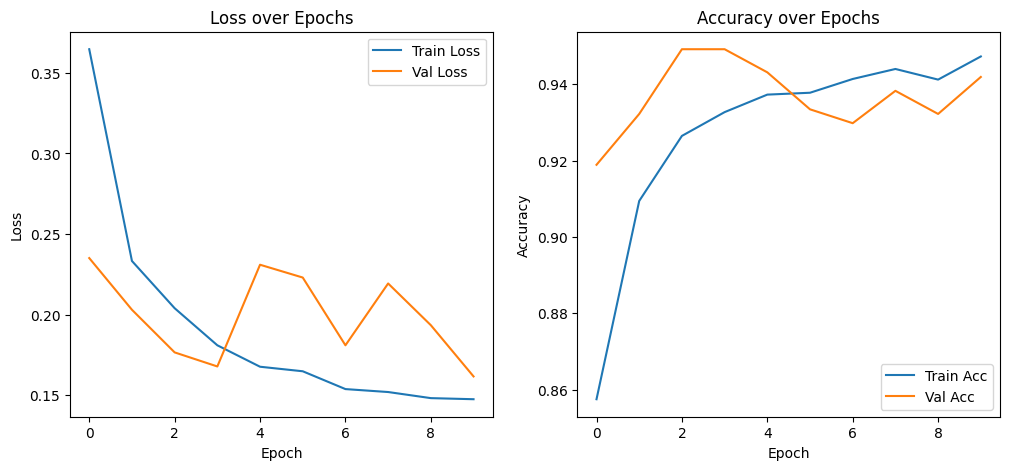

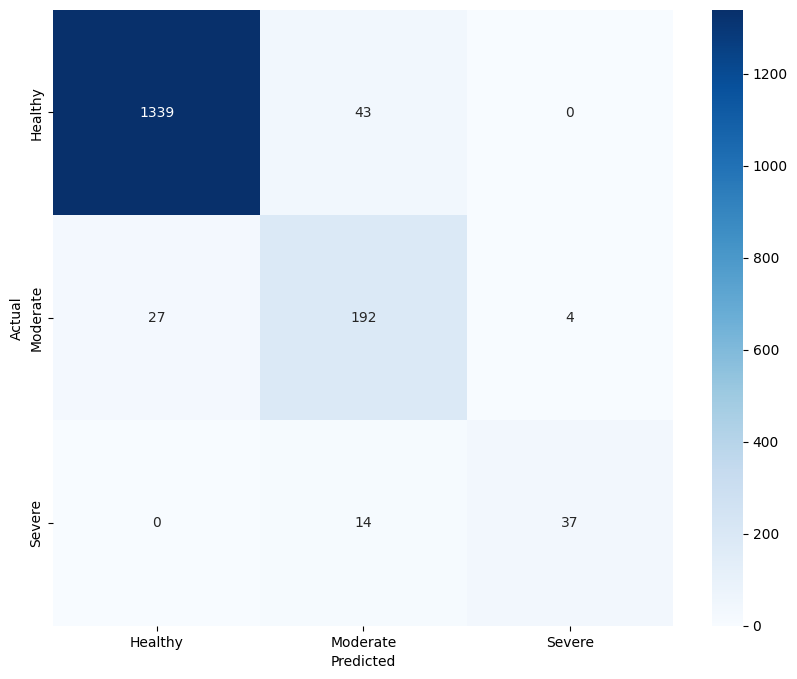

              precision    recall  f1-score   support

     Healthy     0.9802    0.9689    0.9745      1382
    Moderate     0.7711    0.8610    0.8136       223
      Severe     0.9024    0.7255    0.8043        51

    accuracy                         0.9469      1656
   macro avg     0.8846    0.8518    0.8641      1656
weighted avg     0.9497    0.9469    0.9476      1656

Model kaydedildi!


In [7]:
# ===============================
# KÜTÜPHANELER
# ===============================
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.metrics import confusion_matrix, classification_report


# ===============================
# GOOGLE DRIVE BAĞLANTISI
# ===============================
from google.colab import drive
drive.mount('/content/drive/')

# ===============================
# VERİ YOLLARI
# ===============================
train_path = '/content/drive/MyDrive/knee_oa_dataset/train'
valid_path = '/content/drive/My Drive/knee_oa_dataset/val'
test_path = '/content/drive/My Drive/knee_oa_dataset/test'
list_of_classes=['Healthy', 'Doubtful', 'Minimal', 'Moderate', 'Severe']

# ===============================
# VERİ YÜKLEME
# ===============================
def load_df(path):
    filepaths = []
    labels = []
    for klass in os.listdir(path):
        intklass = int(klass)
        label = list_of_classes[intklass]
        classpath = os.path.join(path, klass)
        for f in os.listdir(classpath):
            fpath = os.path.join(classpath, f)
            filepaths.append(fpath)
            labels.append(label)
    return pd.DataFrame({'filepaths': filepaths, 'labels': labels})

train_df = load_df(train_path)
valid_df = load_df(valid_path)
test_df = load_df(test_path)

print('Train:', len(train_df), 'Val:', len(valid_df), 'Test:', len(test_df))

# ===============================
# LABEL BİRLEŞTİRME
# ===============================
def relabel(label):
    if label in ['Healthy', 'Doubtful', 'Minimal']:
        return 'Healthy'
    return label

for df in [train_df, valid_df, test_df]:
    df['labels'] = df['labels'].apply(relabel)

print(train_df['labels'].value_counts())

# ===============================
# SEVERE SINIFINA AUGMENT
# ===============================
severe_df = train_df[train_df['labels'] == 'Severe'].copy()
current_count = len(severe_df)
target_count = 500
num_to_add = target_count - current_count

augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.GaussianBlur(3)
])

augmented_filepaths = []

for i in range(num_to_add):
    original_row = severe_df.sample(1).iloc[0]
    original_path = original_row['filepaths']
    img = Image.open(original_path).convert('RGB')
    img_aug = augment_transform(img)
    folder = os.path.dirname(original_path)
    base = os.path.basename(original_path).split('.')[0]
    new_path = os.path.join(folder, f"{base}_aug{i}.png")
    img_aug.save(new_path)
    augmented_filepaths.append(new_path)

aug_df = pd.DataFrame({
    'filepaths': augmented_filepaths,
    'labels': ['Severe'] * num_to_add
})

train_df = pd.concat([train_df, aug_df], axis=0).reset_index(drop=True)
print('Augment sonrası Severe sayısı:', train_df[train_df['labels']=='Severe'].shape[0])

# ===============================
# DATASET & DATALOADER
# ===============================
img_size = (224, 224)
batch_size = 20

train_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_test_transforms = transforms.Compose([
    transforms.Resize(img_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

class OA_Dataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df.reset_index(drop=True)
        self.transform = transform
        self.classes = sorted(df['labels'].unique())
        self.class2idx = {c: i for i, c in enumerate(self.classes)}

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row['filepaths']).convert('RGB')
        label = self.class2idx[row['labels']]
        if self.transform:
            img = self.transform(img)
        return img, label

train_dataset = OA_Dataset(train_df, transform=train_transforms)
val_dataset = OA_Dataset(valid_df, transform=val_test_transforms)
test_dataset = OA_Dataset(test_df, transform=val_test_transforms)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# ===============================
# MODEL
# ===============================
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

base_model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)
base_model.classifier = nn.Identity()
base_model = base_model.to(device)

class OA_Classifier(nn.Module):
    def __init__(self, base_model, num_classes=3):
        super().__init__()
        self.base = base_model
        self.bn = nn.BatchNorm1d(1280)
        self.fc1 = nn.Linear(1280, 256)
        self.dropout = nn.Dropout(0.4)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        x = self.base(x)
        x = self.bn(x)
        x = torch.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

num_classes = 3
model = OA_Classifier(base_model, num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adamax(model.parameters(), lr=0.001)

# ===============================
# EĞİTİM FONKSİYONU
# ===============================
!pip install tqdm
from tqdm import tqdm

def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    best_val_loss = np.inf
    best_model_wts = None

    # History sözlüğünü oluştur
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': []
    }

    for epoch in range(epochs):
        print(f"\n=== Epoch {epoch+1}/{epochs} started ===")
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for images, labels in tqdm(train_loader, desc="Training", unit="batch"):
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)

        train_loss = running_loss / total
        train_acc = correct / total

        # Validation
        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in tqdm(val_loader, desc="Validation", unit="batch"):
                images = images.to(device)
                labels = labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                _, preds = torch.max(outputs, 1)
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        val_loss /= total
        val_acc = correct / total

        print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")

        # History'yi kaydet
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict().copy()

    model.load_state_dict(best_model_wts)
    return model, history  # history artık döndürülüyor




# ===============================
# TEST FONKSİYONU
# ===============================
def evaluate_model(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    classes = sorted(train_df['labels'].unique())
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', xticklabels=classes, yticklabels=classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    from sklearn.metrics import classification_report
    print(classification_report(y_true, y_pred, target_names=classes, digits=4))


def plot_training_history(history):
    plt.figure(figsize=(12,5))

    # Loss
    plt.subplot(1,2,1)
    plt.plot(history['train_loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Val Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy
    plt.subplot(1,2,2)
    plt.plot(history['train_acc'], label='Train Acc')
    plt.plot(history['val_acc'], label='Val Acc')
    plt.title('Accuracy over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()



# Modeli eğit ve history al
model, history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

# History grafiğini çiz
plot_training_history(history)

# Test et
evaluate_model(model, test_loader)

# Modeli kaydet
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/MobileNet_OA.pth")
print("Model kaydedildi!")


